In [1]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from wOpenTimes import ( 
    WINDOW_OPEN_TIMES
)


def write_data_to_csv(data_frame: pd.DataFrame) -> None:
    """
    This function writes the data to a csv file.
    """
    now = datetime.now()
    #timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"analasys_output_temperature.csv"
    data_frame.to_csv(file_name, index=False)


def read_collected_data() -> list[pd.DataFrame, pd.DataFrame]:
    """
    This function reads the collected data from the csv files and returns a list of two dataframes.
    The dataframes are labeled, their data is interpolated and resampled to 1 minute intervals.
    """
    
    inside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_temperature.csv', parse_dates=['Time'])
    inside_temp_data = inside_temp_data.iloc[1:].reset_index(drop=True)
    inside_temp_data.columns = ['Time', 'Temperature']
    inside_temp_data['Temperature'] = inside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    inside_temp_data['Temperature'] = pd.to_numeric(inside_temp_data['Temperature'], errors='coerce')

    outside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_temperature.csv', parse_dates=['Time'])
    outside_temp_data = outside_temp_data.iloc[1:].reset_index(drop=True)
    outside_temp_data.columns = ['Time', 'Temperature']
    outside_temp_data['Temperature'] = outside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    outside_temp_data['Temperature'] = pd.to_numeric(outside_temp_data['Temperature'], errors='coerce')

    inside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_humidity.csv', parse_dates=['Time'])
    inside_humidity_data = inside_humidity_data.iloc[1:].reset_index(drop=True)
    inside_humidity_data['Humidity'] = inside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    inside_humidity_data['Humidity'] = pd.to_numeric(inside_humidity_data['Humidity'], errors='coerce')

    outside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_humidity.csv', parse_dates=['Time'])
    outside_humidity_data = outside_humidity_data.iloc[1:].reset_index(drop=True)
    outside_humidity_data['Humidity'] = outside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    outside_humidity_data['Humidity'] = pd.to_numeric(outside_humidity_data['Humidity'], errors='coerce')

    outside_temp_data = outside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_temp_data = inside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_humidity_data = inside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    outside_humidity_data = outside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()

    data_list = [inside_temp_data, outside_temp_data, outside_humidity_data, inside_humidity_data]
    return data_list


def normalize_data(data_frame: pd.DataFrame, file_type: str) -> pd.DataFrame:
    """
    This function normalizes the data by removing outliers and interpolating the data to 1 minute intervals.
    """

    if file_type == "temperature":
        value = "Temperature"
        lower_percentile = 0.01
        upper_percentile = 99.99
    elif file_type == "humidity":
        value = "Humidity"
        lower_percentile = 0.1
        upper_percentile = 99.9
    else:
        raise ValueError("Invalid file type")

    lower_threshold = data_frame[value].quantile(lower_percentile / 100)
    upper_threshold = data_frame[value].quantile(upper_percentile / 100)

    df_filtered = data_frame[(data_frame[value] >= lower_threshold) & (data_frame[value] <= upper_threshold)]
    df_filtered = df_filtered.set_index('Time').resample('1T').interpolate('linear').reset_index()

    return df_filtered


def try_different_times(data: pd.DataFrame) -> pd.DataFrame:
    

    for i in range(1, 40):

        results = []

        for start in WINDOW_OPEN_TIMES:

            try:

                start_time = pd.to_datetime(start)
                defined_time_later = start_time + pd.Timedelta(minutes=i)

                temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_inside'].values[0]
                outside_temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_outside'].values[0]
                
                temp_after_defined_time = data.loc[data['Time'] == defined_time_later, 'Temperature_inside'].values[0]
                outside_temp_after_defined_time = data.loc[data['Time'] == defined_time_later, 'Temperature_outside'].values[0]
                
                temp_drop = temp_at_start - temp_after_defined_time

                temp_difference_at_start = temp_at_start - outside_temp_at_start
                temp_difference_at_end = temp_after_defined_time - outside_temp_after_defined_time
                average_temp_difference = (temp_difference_at_start + temp_difference_at_end) / 2

                cooling_rate = (temp_difference_at_start - temp_difference_at_end) / i
                results.append({'temp_difference_at_start': temp_difference_at_start, 'temp_difference_at_end': temp_difference_at_end, 'average_temp_difference': average_temp_difference, 'cooling_rate': cooling_rate})
            
            except Exception as e:

                data.to_csv("error_dump.csv", index=False)
                print(f"Error processing data for window open time: {start}, Exception: {e}")

        results_df_for_test = pd.DataFrame(results)
        results_df_for_test = results_df_for_test.round(3)
        

        #collerate_data = results_df_for_test[['temp_difference_at_start', 'cooling_rate']]
        print(f"Correlation for {i} minutes: ")
        print(results_df_for_test.corr())
        #print(collerate_data.corr())


def experiment_with_values(data):
    # Assuming df has columns: 'Time', 'indoor_temp', 'outdoor_temp'
    data['Time'] = pd.to_datetime(data['Time'])  # Ensure the Time column is datetime type

    # Calculate the difference in indoor temperature
    data['delta_indoor'] = data['Temperature_inside'].diff()

    # Define a threshold for a high drop in temperature (e.g., -1.5°C)
    threshold_drop = -1
    threshold_rise = 1  # The temperature rise threshold to mark the window as closed
    buffer_measurements = 10  # Number of consecutive measurements to check for a rise in temperature

    # Initialize the 'window_open' column
    data['window_open'] = False

    # Step 1: Detect steep drops
    for i in range(1, len(data)):
        if data['delta_indoor'].iloc[i] < threshold_drop:  # Check for a steep drop
            data.loc[i, 'window_open'] = True  # Mark as window open

            # Step 2: Sustain the window open state until temperature rises
            # Check if temperature starts rising continuously for more than 'buffer_measurements' consecutive points
            for j in range(i + 1, len(data)):
                if data['Temperature_inside'].iloc[j] - data['Temperature_inside'].iloc[j-1] > threshold_rise:
                    consecutive_rises = 0
                    for k in range(j, len(data)):
                        if data['Temperature_inside'].iloc[k] - data['Temperature_inside'].iloc[k-1] > threshold_rise:
                            consecutive_rises += 1
                        else:
                            break
                    if consecutive_rises >= buffer_measurements:
                        # Mark window as closed after sustained rise
                        data.loc[i:j, 'window_open'] = False
                        break


data_list = read_collected_data()
inside_temp_data = data_list[0]
outside_temp_data = data_list[1]
outside_humidity_data = data_list[2]
inside_humidity_data = data_list[3]

inside_temp_data = normalize_data(inside_temp_data, "temperature")
outside_temp_data = normalize_data(outside_temp_data, "temperature")

inside_humidity_data = normalize_data(inside_humidity_data, "humidity")
outside_humidity_data = normalize_data(outside_humidity_data, "humidity")

data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'), 
                    on='Time', 
                    suffixes=('_inside', '_outside'))

"""
data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
data = pd.merge_asof(data.sort_values('Time'), 
                    inside_humidity_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
data = pd.merge_asof(data.sort_values('Time'),
                    outside_humidity_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
"""

# Drop rows with NaN values
data = data.dropna()

# Smooth the temperature data
span = 10  # Determines the degree of smoothing
data['Temperature_inside'] = data['Temperature_inside'].ewm(span=span, adjust=False).mean()

# Define the window open times
window_open_times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in WINDOW_OPEN_TIMES]
data['Time'] = pd.to_datetime(data['Time'])
data['Window_Open'] = 0

for start_time in window_open_times:
    end_time = start_time + timedelta(minutes=31)
    data.loc[(data['Time'] >= start_time) & (data['Time'] < end_time), 'Window_Open'] = 1

# Calculate the time it takes to reach 24°C
data["Minutes_to_24"] = np.nan
counter = 0
goal_temperature = 24

for index, row in data.iloc[::-1].iterrows():

    if row['Window_Open'] == 0:
        counter = 0
        continue
    elif row['Temperature_inside'] >= goal_temperature and row['Window_Open'] == 1:
        counter += 1
        data.at[index, 'Minutes_to_24'] = counter

# Drop empty rows with window closed        
data = data.dropna(subset=['Minutes_to_24'])

# Round values to 1 digit
data = data.round(1)

# Create training data
X = data[['Temperature_inside', 'Temperature_outside', 'Window_Open']].astype(float)
y = data['Minutes_to_24']

# Scale the features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)  # Normalize the features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50, 25), (50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.0001],
    'max_iter': [500, 1000, 5000]
}

# Create and train the model
model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    alpha=0.0001,
    learning_rate_init=0.0001,
    activation='relu',
    solver='adam',
    early_stopping=True,
    learning_rate='constant',
    max_iter=500,
    random_state=42
)

# Perform grid search
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(X_train, y_train)

#print("Best Parameters:", grid_search.best_params_)
#print("Best Score:", grid_search.best_score_)
#print("Best Estimator:", grid_search.best_estimator_)


# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


# Example prediction
example_input = np.array([[28, 4, 1]])  # [temperature_inside, temperature_outside, window_is_open]

predicted_time = model.predict(example_input)
print(f"Predicted time to reach 24°C: {predicted_time[0]:.2f} minutes")



Mean Squared Error: 60.08653049678185
R^2 Score: 0.10671119638005899
Predicted time to reach 24°C: 14.72 minutes


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


from wOpenTimes import ( 
    WINDOW_OPEN_TIMES
)

def write_data_to_csv(data_frame: pd.DataFrame) -> None:
    """
    This function writes the data to a csv file.
    """
    now = datetime.now()
    #timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"analasys_output_temperature.csv"
    data_frame.to_csv(file_name, index=False)


def read_collected_data() -> list[pd.DataFrame, pd.DataFrame]:
    """
    This function reads the collected data from the csv files and returns a list of two dataframes.
    The dataframes are labeled, their data is interpolated and resampled to 1 minute intervals.
    """
    
    inside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_temperature.csv', parse_dates=['Time'])
    inside_temp_data = inside_temp_data.iloc[1:].reset_index(drop=True)
    inside_temp_data.columns = ['Time', 'Temperature']
    inside_temp_data['Temperature'] = inside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    inside_temp_data['Temperature'] = pd.to_numeric(inside_temp_data['Temperature'], errors='coerce')

    outside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_temperature.csv', parse_dates=['Time'])
    outside_temp_data = outside_temp_data.iloc[1:].reset_index(drop=True)
    outside_temp_data.columns = ['Time', 'Temperature']
    outside_temp_data['Temperature'] = outside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    outside_temp_data['Temperature'] = pd.to_numeric(outside_temp_data['Temperature'], errors='coerce')

    inside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_humidity.csv', parse_dates=['Time'])
    inside_humidity_data = inside_humidity_data.iloc[1:].reset_index(drop=True)
    inside_humidity_data['Humidity'] = inside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    inside_humidity_data['Humidity'] = pd.to_numeric(inside_humidity_data['Humidity'], errors='coerce')

    outside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_humidity.csv', parse_dates=['Time'])
    outside_humidity_data = outside_humidity_data.iloc[1:].reset_index(drop=True)
    outside_humidity_data['Humidity'] = outside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    outside_humidity_data['Humidity'] = pd.to_numeric(outside_humidity_data['Humidity'], errors='coerce')

    outside_temp_data = outside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_temp_data = inside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_humidity_data = inside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    outside_humidity_data = outside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()

    data_list = [inside_temp_data, outside_temp_data, outside_humidity_data, inside_humidity_data]
    return data_list


def normalize_data(data_frame: pd.DataFrame, file_type: str) -> pd.DataFrame:
    """
    This function normalizes the data by removing outliers and interpolating the data to 1 minute intervals.
    """

    if file_type == "temperature":
        value = "Temperature"
        lower_percentile = 0.01
        upper_percentile = 99.99
    elif file_type == "humidity":
        value = "Humidity"
        lower_percentile = 0.1
        upper_percentile = 99.9
    else:
        raise ValueError("Invalid file type")

    lower_threshold = data_frame[value].quantile(lower_percentile / 100)
    upper_threshold = data_frame[value].quantile(upper_percentile / 100)

    df_filtered = data_frame[(data_frame[value] >= lower_threshold) & (data_frame[value] <= upper_threshold)]
    df_filtered = df_filtered.set_index('Time').resample('1T').interpolate('linear').reset_index()

    return df_filtered


def try_different_times(data: pd.DataFrame) -> pd.DataFrame:
    

    for i in range(1, 40):

        results = []

        for start in WINDOW_OPEN_TIMES:

            try:

                start_time = pd.to_datetime(start)
                defined_time_later = start_time + pd.Timedelta(minutes=i)

                temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_inside'].values[0]
                outside_temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_outside'].values[0]
                
                temp_after_defined_time = data.loc[data['Time'] == defined_time_later, 'Temperature_inside'].values[0]
                outside_temp_after_defined_time = data.loc[data['Time'] == defined_time_later, 'Temperature_outside'].values[0]
                
                temp_drop = temp_at_start - temp_after_defined_time

                temp_difference_at_start = temp_at_start - outside_temp_at_start
                temp_difference_at_end = temp_after_defined_time - outside_temp_after_defined_time
                average_temp_difference = (temp_difference_at_start + temp_difference_at_end) / 2

                cooling_rate = (temp_difference_at_start - temp_difference_at_end) / i
                results.append({'temp_difference_at_start': temp_difference_at_start, 'temp_difference_at_end': temp_difference_at_end, 'average_temp_difference': average_temp_difference, 'cooling_rate': cooling_rate})
            
            except Exception as e:

                data.to_csv("error_dump.csv", index=False)
                print(f"Error processing data for window open time: {start}, Exception: {e}")

        results_df_for_test = pd.DataFrame(results)
        results_df_for_test = results_df_for_test.round(3)
        

        #collerate_data = results_df_for_test[['temp_difference_at_start', 'cooling_rate']]
        print(f"Correlation for {i} minutes: ")
        print(results_df_for_test.corr())
        #print(collerate_data.corr())


def experiment_with_values(data):
    # Assuming df has columns: 'Time', 'indoor_temp', 'outdoor_temp'
    data['Time'] = pd.to_datetime(data['Time'])  # Ensure the Time column is datetime type

    # Calculate the difference in indoor temperature
    data['delta_indoor'] = data['Temperature_inside'].diff()

    # Define a threshold for a high drop in temperature (e.g., -1.5°C)
    threshold_drop = -1
    threshold_rise = 1  # The temperature rise threshold to mark the window as closed
    buffer_measurements = 10  # Number of consecutive measurements to check for a rise in temperature

    # Initialize the 'window_open' column
    data['window_open'] = False

    # Step 1: Detect steep drops
    for i in range(1, len(data)):
        if data['delta_indoor'].iloc[i] < threshold_drop:  # Check for a steep drop
            data.loc[i, 'window_open'] = True  # Mark as window open

            # Step 2: Sustain the window open state until temperature rises
            # Check if temperature starts rising continuously for more than 'buffer_measurements' consecutive points
            for j in range(i + 1, len(data)):
                if data['Temperature_inside'].iloc[j] - data['Temperature_inside'].iloc[j-1] > threshold_rise:
                    consecutive_rises = 0
                    for k in range(j, len(data)):
                        if data['Temperature_inside'].iloc[k] - data['Temperature_inside'].iloc[k-1] > threshold_rise:
                            consecutive_rises += 1
                        else:
                            break
                    if consecutive_rises >= buffer_measurements:
                        # Mark window as closed after sustained rise
                        data.loc[i:j, 'window_open'] = False
                        break


data_list = read_collected_data()
inside_temp_data = data_list[0]
outside_temp_data = data_list[1]
outside_humidity_data = data_list[2]
inside_humidity_data = data_list[3]

inside_temp_data = normalize_data(inside_temp_data, "temperature")
outside_temp_data = normalize_data(outside_temp_data, "temperature")

inside_humidity_data = normalize_data(inside_humidity_data, "humidity")
outside_humidity_data = normalize_data(outside_humidity_data, "humidity")

data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'), 
                    on='Time', 
                    suffixes=('_inside', '_outside'))

"""
data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
data = pd.merge_asof(data.sort_values('Time'), 
                    inside_humidity_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
data = pd.merge_asof(data.sort_values('Time'),
                    outside_humidity_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
"""

# Drop rows with NaN values
data = data.dropna()

# Smooth the temperature data
span = 10  # Determines the degree of smoothing
data['Temperature_inside'] = data['Temperature_inside'].ewm(span=span, adjust=False).mean()

# Define the window open times
window_open_times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in WINDOW_OPEN_TIMES]
data['Time'] = pd.to_datetime(data['Time'])
data['Window_Open'] = 0

for start_time in window_open_times:
    end_time = start_time + timedelta(minutes=31)
    data.loc[(data['Time'] >= start_time) & (data['Time'] < end_time), 'Window_Open'] = 1

# Calculate the time it takes to reach 24°C
data["Minutes_to_24"] = np.nan
counter = 0
goal_temperature = 24

for index, row in data.iloc[::-1].iterrows():

    if row['Window_Open'] == 0:
        counter = 0
        continue
    elif row['Temperature_inside'] >= goal_temperature and row['Window_Open'] == 1:
        counter += 1
        data.at[index, 'Minutes_to_24'] = counter

# Drop empty rows with window closed        
data = data.dropna(subset=['Minutes_to_24'])

# Round values to 1 digit
data = data.round(1)

# Create training data
X = data[['Temperature_inside', 'Temperature_outside', 'Window_Open']].astype(float)
y = data['Minutes_to_24']

# Scale the features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)  # Normalize the features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35],
    'n_estimators': [50, 75, 100, 125, 150, 200, 500, 1000],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create and train the model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2
    )

# Perform grid search
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
#grid_search.fit(X_train, y_train)

#print("Best Parameters:", grid_search.best_params_)
#print("Best Score:", grid_search.best_score_)
#print("Best Estimator:", grid_search.best_estimator_)


# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


# Example prediction
example_input = np.array([[29, 14, 1]])  # [temperature_inside, temperature_outside, window_is_open]

predicted_time = model.predict(example_input)
print(f"Predicted time to reach 24°C: {predicted_time[0]:.2f} minutes")



Mean Squared Error: 13.690648381911092
R^2 Score: 0.7964651509623502
Predicted time to reach 24°C: 30.11 minutes


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from scipy.signal import savgol_filter


from wOpenTimes import ( 
    WINDOW_OPEN_TIMES
)

def write_data_to_csv(data_frame: pd.DataFrame) -> None:
    """
    This function writes the data to a csv file.
    """
    now = datetime.now()
    #timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"analasys_output_temperature.csv"
    data_frame.to_csv(file_name, index=False)


def read_collected_data() -> list[pd.DataFrame, pd.DataFrame]:
    """
    This function reads the collected data from the csv files and returns a list of two dataframes.
    The dataframes are labeled, their data is interpolated and resampled to 1 minute intervals.
    """
    
    inside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_temperature.csv', parse_dates=['Time'])
    inside_temp_data = inside_temp_data.iloc[1:].reset_index(drop=True)
    inside_temp_data.columns = ['Time', 'Temperature']
    inside_temp_data['Temperature'] = inside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    inside_temp_data['Temperature'] = pd.to_numeric(inside_temp_data['Temperature'], errors='coerce')

    outside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_temperature.csv', parse_dates=['Time'])
    outside_temp_data = outside_temp_data.iloc[1:].reset_index(drop=True)
    outside_temp_data.columns = ['Time', 'Temperature']
    outside_temp_data['Temperature'] = outside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
    outside_temp_data['Temperature'] = pd.to_numeric(outside_temp_data['Temperature'], errors='coerce')

    inside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_humidity.csv', parse_dates=['Time'])
    inside_humidity_data = inside_humidity_data.iloc[1:].reset_index(drop=True)
    inside_humidity_data['Humidity'] = inside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    inside_humidity_data['Humidity'] = pd.to_numeric(inside_humidity_data['Humidity'], errors='coerce')

    outside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_humidity.csv', parse_dates=['Time'])
    outside_humidity_data = outside_humidity_data.iloc[1:].reset_index(drop=True)
    outside_humidity_data['Humidity'] = outside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
    outside_humidity_data['Humidity'] = pd.to_numeric(outside_humidity_data['Humidity'], errors='coerce')

    outside_temp_data = outside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_temp_data = inside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    inside_humidity_data = inside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
    outside_humidity_data = outside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()

    data_list = [inside_temp_data, outside_temp_data, outside_humidity_data, inside_humidity_data]
    return data_list


def normalize_data(data_frame: pd.DataFrame, file_type: str) -> pd.DataFrame:
    """
    This function normalizes the data by removing outliers and interpolating the data to 1 minute intervals.
    """

    if file_type == "temperature":
        value = "Temperature"
        lower_percentile = 0.01
        upper_percentile = 99.99
    elif file_type == "humidity":
        value = "Humidity"
        lower_percentile = 0.1
        upper_percentile = 99.9
    else:
        raise ValueError("Invalid file type")

    lower_threshold = data_frame[value].quantile(lower_percentile / 100)
    upper_threshold = data_frame[value].quantile(upper_percentile / 100)

    df_filtered = data_frame[(data_frame[value] >= lower_threshold) & (data_frame[value] <= upper_threshold)]
    df_filtered = df_filtered.set_index('Time').resample('1T').interpolate('linear').reset_index()

    return df_filtered


def try_different_times(data: pd.DataFrame) -> pd.DataFrame:
    

    for i in range(1, 40):

        results = []

        for start in WINDOW_OPEN_TIMES:

            try:

                start_time = pd.to_datetime(start)
                defined_time_later = start_time + pd.Timedelta(minutes=i)

                temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_inside'].values[0]
                outside_temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_outside'].values[0]
                
                temp_after_defined_time = data.loc[data['Time'] == defined_time_later, 'Temperature_inside'].values[0]
                outside_temp_after_defined_time = data.loc[data['Time'] == defined_time_later, 'Temperature_outside'].values[0]
                
                temp_drop = temp_at_start - temp_after_defined_time

                temp_difference_at_start = temp_at_start - outside_temp_at_start
                temp_difference_at_end = temp_after_defined_time - outside_temp_after_defined_time
                average_temp_difference = (temp_difference_at_start + temp_difference_at_end) / 2

                cooling_rate = (temp_difference_at_start - temp_difference_at_end) / i
                results.append({'temp_difference_at_start': temp_difference_at_start, 'temp_difference_at_end': temp_difference_at_end, 'average_temp_difference': average_temp_difference, 'cooling_rate': cooling_rate})
            
            except Exception as e:

                data.to_csv("error_dump.csv", index=False)
                print(f"Error processing data for window open time: {start}, Exception: {e}")

        results_df_for_test = pd.DataFrame(results)
        results_df_for_test = results_df_for_test.round(3)
        

        #collerate_data = results_df_for_test[['temp_difference_at_start', 'cooling_rate']]
        print(f"Correlation for {i} minutes: ")
        print(results_df_for_test.corr())
        #print(collerate_data.corr())


def experiment_with_values(data):
    # Assuming df has columns: 'Time', 'indoor_temp', 'outdoor_temp'
    data['Time'] = pd.to_datetime(data['Time'])  # Ensure the Time column is datetime type

    # Calculate the difference in indoor temperature
    data['delta_indoor'] = data['Temperature_inside'].diff()

    # Define a threshold for a high drop in temperature (e.g., -1.5°C)
    threshold_drop = -1
    threshold_rise = 1  # The temperature rise threshold to mark the window as closed
    buffer_measurements = 10  # Number of consecutive measurements to check for a rise in temperature

    # Initialize the 'window_open' column
    data['window_open'] = False

    # Step 1: Detect steep drops
    for i in range(1, len(data)):
        if data['delta_indoor'].iloc[i] < threshold_drop:  # Check for a steep drop
            data.loc[i, 'window_open'] = True  # Mark as window open

            # Step 2: Sustain the window open state until temperature rises
            # Check if temperature starts rising continuously for more than 'buffer_measurements' consecutive points
            for j in range(i + 1, len(data)):
                if data['Temperature_inside'].iloc[j] - data['Temperature_inside'].iloc[j-1] > threshold_rise:
                    consecutive_rises = 0
                    for k in range(j, len(data)):
                        if data['Temperature_inside'].iloc[k] - data['Temperature_inside'].iloc[k-1] > threshold_rise:
                            consecutive_rises += 1
                        else:
                            break
                    if consecutive_rises >= buffer_measurements:
                        # Mark window as closed after sustained rise
                        data.loc[i:j, 'window_open'] = False
                        break


data_list = read_collected_data()
inside_temp_data = data_list[0]
outside_temp_data = data_list[1]
outside_humidity_data = data_list[2]
inside_humidity_data = data_list[3]

inside_temp_data = normalize_data(inside_temp_data, "temperature")
outside_temp_data = normalize_data(outside_temp_data, "temperature")

inside_humidity_data = normalize_data(inside_humidity_data, "humidity")
outside_humidity_data = normalize_data(outside_humidity_data, "humidity")

data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'), 
                    on='Time', 
                    suffixes=('_inside', '_outside'))

"""
data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
data = pd.merge_asof(data.sort_values('Time'), 
                    inside_humidity_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
data = pd.merge_asof(data.sort_values('Time'),
                    outside_humidity_data.sort_values('Time'),
                    on='Time', 
                    suffixes=('_inside', '_outside'))
"""

# Drop rows with NaN values
data = data.dropna()

pre_smoothed_data = data.copy()

# Smooth the temperature data
#span = 15  # Determines the degree of smoothing
#data['Temperature_inside'] = data['Temperature_inside'].ewm(span=span, adjust=False).mean()

# Apply Savitzky-Golay filter
window_size = 9  # Choose an odd number (larger values = more smoothing)
poly_order = 2    # Polynomial order
data['Temperature_inside'] = savgol_filter(data['Temperature_inside'], window_size, poly_order)

# Define the window open times
window_open_times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in WINDOW_OPEN_TIMES]
data['Time'] = pd.to_datetime(data['Time'])
data['Window_Open'] = 0

for start_time in window_open_times:
    end_time = start_time + timedelta(minutes=31)
    data.loc[(data['Time'] >= start_time) & (data['Time'] < end_time), 'Window_Open'] = 1

# Calculate the time it takes to reach 24°C
data["Minutes_to_24"] = np.nan
counter = 0
goal_temperature = 24

for index, row in data.iloc[::-1].iterrows():

    if row['Window_Open'] == 0:
        counter = 0
        continue
    elif row['Temperature_inside'] >= goal_temperature and row['Window_Open'] == 1:
        counter += 1
        data.at[index, 'Minutes_to_24'] = counter

# Drop empty rows with window closed        
data = data.dropna(subset=['Minutes_to_24'])

# Round values to 1 digit
data = data.round(2)

# Create training data
X = data[['Temperature_inside', 'Temperature_outside', 'Window_Open']].astype(float)
y = data['Minutes_to_24']

# Scale the features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)  # Normalize the features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (50,), (10, 10), (20, 20), (30, 30), (10, 10, 10), (50, 10), (50, 30), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.0001],
    'max_iter': [200, 500, 1000, 2000]
}

# Create and train the model
model = MLPRegressor(
    #hidden_layer_sizes=(100, 50),
    #alpha=0.0001,
    #learning_rate_init=0.0001,
    activation='relu',
    solver='adam',
    early_stopping=True,
    learning_rate='constant',
    #max_iter=500,
    random_state=42
)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Best Estimator:", grid_search.best_estimator_)

best_model = grid_search.best_estimator_

# Evaluate on test data (assuming you have a separate test set)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

Best Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate_init': 0.0001, 'max_iter': 500}
Best Score: -64.15003795907349
Best Estimator: MLPRegressor(early_stopping=True, hidden_layer_sizes=(10, 10, 10),
             learning_rate_init=0.0001, max_iter=500, random_state=42)
Mean Squared Error: 59.54758834402699


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached 

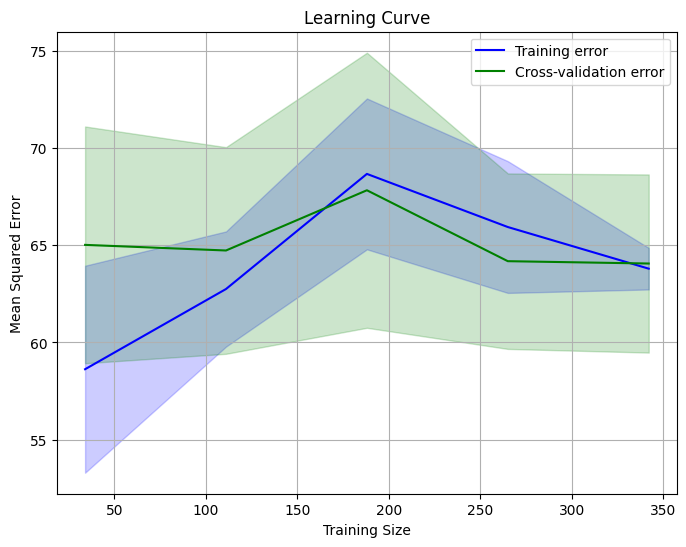

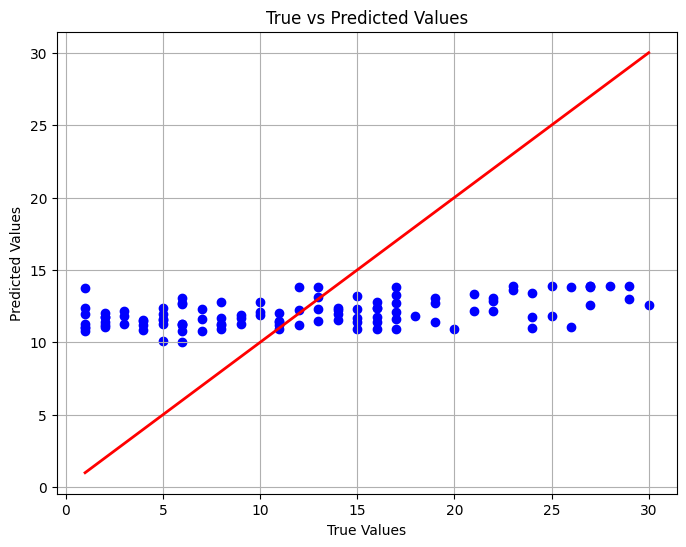

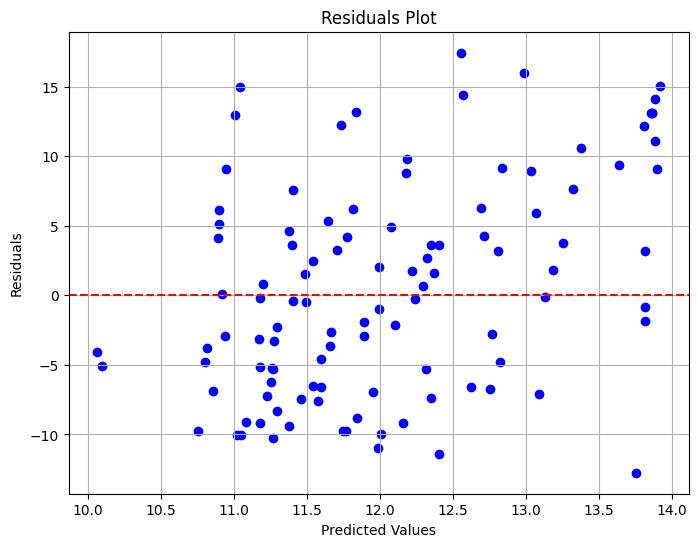

In [4]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and std deviation for train and test scores
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training error", color='blue')
plt.plot(train_sizes, test_mean, label="Cross-validation error", color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

In [5]:
# Example prediction
example_input = np.array([[27.5, 2.7, 1]])  # [temperature_inside, temperature_outside, window_is_open]

predicted_time = best_model.predict(example_input)
print(f"Predicted time to reach 24°C: {predicted_time[0]:.2f} minutes")

Predicted time to reach 24°C: 11.74 minutes


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
